# Description

## Packages

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.keras.utils.generic_utils import to_list
from tensorflow.keras.models import save_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, FalsePositives, \
                                    TruePositives, TrueNegatives, FalseNegatives, AUC, Metric

# tf.get_logger().setLevel('ERROR')

## Set random seed

Still having some issues... seeding is not applied somehow

In [2]:
# seed(20192020)
# set_seed(20192020)

## Activate GPU devices

In [3]:
# Set GPU usage and memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"Tensorflow ({tf.__version__}) recognises {len(physical_devices)} GPU(s)\nEnabling GPU memory growth")
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, enable=True) 

### Activate distribute strategy to distribute GPU computations across available GPUs

In [5]:
mirrored_strategy = tf.distribute.MirroredStrategy()

## Chaos game representation

This is an example of the CGR images which the model will be training on.

<!-- ![CGR represention of virus protein sequences](./plots.png) -->
<img src=./plots.png width=600 height=500>

## Data loading

### Using keras image data generator

In [6]:
# directories = [os.path.join('../../pipeline-output/ZoonosisData', dtry) for dtry in ['train', 'test']]
directories = [os.path.join('/scratch3/users/rserage/ZoonosisData', dtry) for dtry in ['train', 'test']]

BATCH_SIZE = 64

TARGET_SIZE = (128,128)

test_data_generator = ImageDataGenerator(rescale=1./255) # Specifically for test data

train_val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2) # For training and validation split

train_data_iterator = train_val_data_generator.flow_from_directory(directories[0], 
                                              target_size=TARGET_SIZE,
                                              color_mode='grayscale', 
                                              class_mode='binary',
                                              classes=['human-false', 'human-true'],
                                              batch_size=BATCH_SIZE,
                                              # seed=19980603,
                                              subset='training') # Specifies subset, ignored in test

validation_data_iterator = train_val_data_generator.flow_from_directory(directories[0], 
                                              target_size=TARGET_SIZE,
                                              color_mode='grayscale', 
                                              class_mode='binary',
                                              classes=['human-false', 'human-true'],
                                              batch_size=BATCH_SIZE,
                                              # seed=19980603,
                                              subset='validation')

test_data_iterator = test_data_generator.flow_from_directory(directories[1], 
                                              target_size=TARGET_SIZE,
                                              color_mode='grayscale', 
                                              class_mode='binary', shuffle=False,
                                              classes=['human-false', 'human-true'],
                                              batch_size=BATCH_SIZE,
                                              # seed=19980603
                                                            )

Found 65753 images belonging to 2 classes.
Found 16437 images belonging to 2 classes.
Found 20548 images belonging to 2 classes.


In [11]:
65753/64

1027.390625

In [10]:
16437/64

256.828125

In [14]:
20548/64

321.0625

## Model building, compilation and training
#### Loads model if it exists

#### Custom metrics (MCC)

In [7]:
class MatthewsCorrelationCoefficient(Metric):
    """
    MCC = (TP * TN) - (FP * FN) /
          ((TP + FP) * (TP + FN) * (TN + FP ) * (TN + FN))^(1/2)
    Args:
        num_classes : Number of unique classes in the dataset.
        name: (Optional) String name of the metric instance.
        dtype: (Optional) Data type of the metric result.
    Usage:
    """
    def __init__(self,thresholds=None, top_k=None, class_id=None, name=None, dtype=None):
        super(MatthewsCorrelationCoefficient, self).__init__(name=name, dtype=dtype)
        self.init_thresholds = thresholds
        self.top_k = top_k
        self.class_id = class_id

        default_threshold = 0.7 if top_k is None else metrics_utils.NEG_INF
        self.thresholds = metrics_utils.parse_init_thresholds(
            thresholds, default_threshold=default_threshold)
        self._thresholds_distributed_evenly = (
            metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
        self.true_positives = self.add_weight(
            'true_positives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)
        self.false_positives = self.add_weight(
            'false_positives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)
        self.true_negatives = self.add_weight(
            'true_negatives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)
        self.false_negatives = self.add_weight(
            'false_negatives',
            shape=(len(self.thresholds),),
            initializer=tf.compat.v1.zeros_initializer)

    def update_state(self, y_true, y_pred, sample_weight=None):
        return metrics_utils.update_confusion_matrix_variables(
            {
                metrics_utils.ConfusionMatrix.TRUE_POSITIVES: self.true_positives,
                metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives,
                metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
                metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives,
            },
            y_true,
            y_pred,
            thresholds=self.thresholds,
            thresholds_distributed_evenly=self._thresholds_distributed_evenly,
            top_k=self.top_k,
            class_id=self.class_id,
            sample_weight=sample_weight)

    def result(self):
        """
        MCC = (TP * TN) - (FP * FN) /
            ((TP + FP) * (TP + FN) * (TN + FP ) * (TN + FN))^(1/2)
        """
        A = tf.math.subtract(
            tf.math.multiply(self.true_positives, self.true_negatives),
            tf.math.multiply(self.false_positives, self.false_negatives)) # (TP * TN) - (FP * FN)

        B = tf.math.multiply(tf.math.add(self.true_positives, self.false_positives),
                            tf.math.add(self.true_positives, self.false_negatives)) # (TP + FP) * (TP + FN)
        C = tf.math.multiply(tf.math.add(self.true_negatives, self.false_positives),
                            tf.math.add(self.true_negatives, self.false_negatives)) # (TN + FP ) * (TN + FN)

        D = tf.math.sqrt(tf.math.multiply(B, C))


        result = tf.math.divide_no_nan(A, D)

        return result[0] if len(self.thresholds) == 1 else result

    def reset_state(self):
        num_thresholds = len(to_list(self.thresholds))
        backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                                 for v in (self.true_positives,
                                           self.false_positives,
                                           self.true_negatives,
                                           self.false_negatives)])

    def get_config(self):
        config = {
            'thresholds': self.init_thresholds,
            'top_k': self.top_k,
            'class_id': self.class_id
        }
        base_config = super(MatthewsCorrelationCoefficient, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

#### Callback functions

In [8]:
logs = CSVLogger('logs.csv')

model_checkpoint_callback = ModelCheckpoint(
    filepath='check.ckpt',
    save_weights_only=True,
    monitor='MCC',
    mode='max',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_AUC',
    factor=0.2, patience=3,
    min_lr=0.001
)

### Model training

The model trains while saving the best model to a checkpoint with every epoch. Training logs are also generated as a csv file.

In [ ]:
thresh = 0.8

with mirrored_strategy.scope():
    
    model = keras.models.Sequential([
        # keras.layers.BatchNormalization(input_shape=(300, 300, 1)),
        # keras.layers.Conv2D(128, kernel_size=(3,3),
        #                     activation='relu', padding='same',
        #                     bias_regularizer=tf.keras.regularizers.l2()),
        # keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
        # keras.layers.BatchNormalization(),
        keras.layers.Conv2D(48, input_shape=(128,128,1), kernel_size=(3,3), activation='relu', padding='same',
                            bias_regularizer=tf.keras.regularizers.l2()),
        keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(96, kernel_size=(3,3), activation='relu', padding='same',
                            bias_regularizer=tf.keras.regularizers.l2()),
        keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
        # keras.layers.BatchNormalization(),
        # keras.layers.Conv2D(1024, kernel_size=(3,3), activation='relu', padding='same',
        #                     bias_regularizer=tf.keras.regularizers.l2()),
        # keras.layers.MaxPool2D(pool_size=(2,2), padding='same'),
        # keras.layers.BatchNormalization(),
        # keras.layers.Dropout(0.4),
        keras.layers.Flatten(),
        # keras.layers.Dense(units=512, activation='relu',
        #                    bias_regularizer=tf.keras.regularizers.l2()),
        # keras.layers.Dropout(0.4),
        # keras.layers.Dense(units=1024, activation='relu',
        #                    bias_regularizer=tf.keras.regularizers.l2()),
        # keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid',
                           bias_regularizer=tf.keras.regularizers.l2())
    ])
    recall = Recall(name = "Recall", thresholds=thresh)
    precision = Precision(name = "Precision", thresholds=thresh)
    accuracy = BinaryAccuracy(threshold=thresh)
    false_positives = FalsePositives(name="FP",thresholds=thresh)
    true_positives = TruePositives(name="TP", thresholds=thresh)
    true_negatives = TrueNegatives(name="TN", thresholds=thresh)
    false_negatives = FalseNegatives(name="FN", thresholds=thresh)
    methewsCC = MatthewsCorrelationCoefficient(name="MCC", thresholds=thresh)
    auc_roc = AUC(name='AUC')



model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=[
        accuracy,
        recall,
        precision,
        false_positives,
        true_positives,
        true_negatives,
        false_negatives,
        methewsCC,
        auc_roc
    ])

history = model.fit(
    train_data_iterator, 
    steps_per_epoch=1028,
    validation_data=validation_data_iterator, 
    validation_steps=257,
    epochs=15,
    verbose=1,
    # use_multiprocessing=True,
    # shuffle=True,
#     class_weight={0:4.11808002, 1:0.56909742},
    callbacks=[
        logs,
        model_checkpoint_callback,
        reduce_lr
        ])

Epoch 1/15
 420/1028 [===========>..................] - ETA: 31:22 - loss: 0.9609 - binary_accuracy: 0.7083 - Recall: 0.5823 - Precision: 0.9285 - FP: 760.0000 - TP: 9873.0000 - TN: 9166.0000 - FN: 7081.0000 - MCC: 0.4992 - AUC: 0.8688

## Save best model

Useful in the script but not necessary in this the notebook context

In [13]:
model.load_weights('check.ckpt')
save_model(model, 'model')

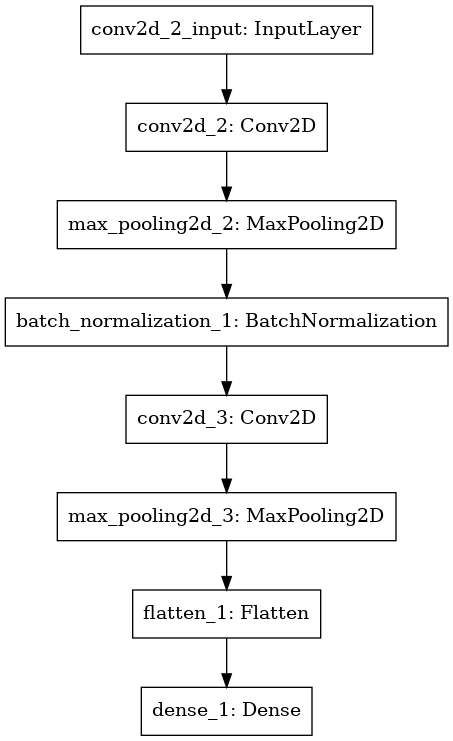

In [31]:
plot_model(model, "Zoonopred.png")

## Model evaluation

In [15]:
model.evaluate(test_data_iterator, return_dict=True, steps=321)

321/321 [==============================] - 791s 2s/step - loss: 0.1006 - binary_accuracy: 0.9616 - Recall: 0.9544 - Precision: 0.9835 - FP: 205.0000 - TP: 12234.0000 - TN: 7521.0000 - FN: 584.0000 - MCC: 0.9196 - AUC: 0.9930


{'loss': 0.10058493912220001,
 'binary_accuracy': 0.9615946412086487,
 'Recall': 0.9544390439987183,
 'Precision': 0.9835195541381836,
 'FP': 205.0,
 'TP': 12234.0,
 'TN': 7521.0,
 'FN': 584.0,
 'MCC': 0.9196485280990601,
 'AUC': 0.9929676651954651}

In [30]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 1028}

In [23]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'Recall', 'Precision', 'FP', 'TP', 'TN', 'FN', 'MCC', 'AUC', 'val_loss', 'val_binary_accuracy', 'val_Recall', 'val_Precision', 'val_FP', 'val_TP', 'val_TN', 'val_FN', 'val_MCC', 'val_AUC', 'lr'])

### Model training with cross validation

In [ ]:
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.utils import class_weight
# import numpy as np

In [9]:
# os.getcwd()

In [10]:
# # os.chdir('/home/campbell/Documents/Rudolph/data/')
# dataset_directory = '/home/campbell/Documents/Rudolph/data/MetazoaZoonosisData/train'
# data_subdirectories = ['human-false', 'human-true']

In [11]:
# X, y = createImageData(data_dir=dataset_directory, subdir=data_subdirectories)

# print(X.shape)
# print(y.shape)

In [12]:
# seed = 960505
# def balanced_flow_from_directory(flow_from_directory):
#     rus = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)
# #     X_sample, y_sample = rus.fit_resample(X, y)
#     for x, y in flow_from_directory.get(2):
#          yield rus.fit_resample(x, y)

# train_data = balanced_flow_from_directory(train_data_iterator)

In [16]:
# model_checkpoint = 'check.ckpt'
# # logs = 'logs.csv'
# model_checkpoint_callback = ModelCheckpoint(
#     filepath=model_checkpoint,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

# seed = 960505

# # Evaluating a model with random oversampling and undersampling
# ## Resample data
# # Sampling strategy resamples dataset to a 2:1 ratio of the majority class
# # rus = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)
# # X_sample, y_sample = rus.fit_resample(X, y)

# # print(X_sample.shape)
# # print(y_sample.shape)

# ## Define cross validator
# cv = RepeatedStratifiedKFold(n_splits=5, random_state=seed)

# ## Define model
# model = ConvNetModel()

# # parameters passed to fit method
# fit_params = {'shuffle':True, 'epochs':100,
#               'verbose':0, 'class_weight':class_weights,
#               'callbacks':[CSVLogger('logs.csv'), model_checkpoint_callback]}

# # Train model with 5-fold cross validation
# scores = cross_val_score(model,
#                          train_data_iterator,
#                          scoring='f1',
#                          cv=cv, #n_jobs=1,
#                          fit_params=fit_params)

# score = np.mean(scores)
# print('F1 Score: %.3f' % score)

In [ ]:
# import cv2

# def img_proc(image):
#     img_mtx = cv2.subtract(255, cv2.imread(image, cv2.IMREAD_GRAYSCALE))
#     save_as = os.path.join(path, image)
#     cv2.imwrite(save_as, img_mtx)

# from concurrent.futures import ThreadPoolExecutor

# images_list = []

# for directory in dirs:
#     dir_items = os.listdir(directory)
#     dir_items_full_name = [os.path.join(directory, item) for item in dir_items]
#     images_list.append(dir_items_full_name)

# with ThreadPoolExecutor() as executor:
#     list(tqdm(executor.map(img_proc, images_list), total=len(images_list)))